#Introduction
In this project, we aim to predict average life expectancy of a country. We do this by examining key factors such as unemployment rates, undernourishment, and even public defecation (which we have data on for some reason). Now we classify the life expectancy for each country as either above or below average and use a naive bayes classifier and random forest to predict for each country if they're above or below average. In the end, our random forest is almost 98% accurate!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk openjdk-8-jdk-headless
  openjdk-8-jre openjdk-8-jre-headless x11-utils
0 upgraded, 15 newly installed, 0 to remove and 37 not upgraded.
Need to get 43.5 MB of archives.
After this 

In [3]:
import pandas as pd
print(pd.__version__ == '1.1.5')
import numpy as np 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os

True


In [4]:
!apt update
!apt install gcc python-dev libkrb5-dev

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [1,820 kB]
Ign:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:13 https://developer.download

In [5]:
raw_data_df = pd.read_csv('/content/drive/MyDrive/jawns/data.csv', error_bad_lines=False)
raw_data_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
0,Arab World,ARB,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,133.555013,134.159119,134.857912,134.504576,134.105211,133.569626,132.675635,131.665502,129.19098,126.736756,124.382809,122.133431,120.020186,118.087531,116.132988,114.100918,111.980005,109.783822,106.033489,102.341721,98.739002,95.241251,91.791192,88.001177,84.207256,80.359323,76.441596,72.51458,71.170664,69.888768,69.004413,67.755992,66.928451,64.948968,62.922778,60.707070,58.596631,56.440128,55.531540,54.658781,53.831410,52.901528,51.990793,51.522856,51.103250,50.732590,50.329135,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,NaN,NaN
3,Arab World,ARB,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89005,Zimbabwe,ZWE,Use of insecticide-treated bed nets (% of unde...,SH.MLR.NETS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.100000,NaN,NaN,17.300000,NaN,9.700000,NaN,NaN,26.800000,NaN,NaN
89006,Zimbabwe,ZWE,Use of Intermittent Preventive Treatment of ma...,SH.MLR.SPF2.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.300000,NaN,NaN,13.900000,NaN,7.300000,NaN,NaN,12.900000,NaN,NaN
89007,Zimbabwe,ZWE,Vitamin A supplementation coverage rate (% of ...,SN.ITK.VITA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,19.000000,20.000000,81.000000,67.000000,83.000000,0.000000,77.000000,49.000000,47.000000,61.000000,34.000000,32.000000,NaN,NaN
89008,Zimbabwe,ZWE,Wanted fertility rate (births per woman),SP.DYN.WFRT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.400000,NaN,NaN,NaN,NaN,NaN,3.500000,NaN,NaN,NaN,NaN,3.400000,NaN,NaN,NaN,NaN,NaN,NaN,3.300000,NaN,NaN,NaN,NaN,3.500000,NaN,NaN,NaN,NaN,NaN


# Cleaning
Ok, so for this part, as we saw above, we have a huge amount of factors that are super interesting, but so many of those are poorly filled out. For that reason, we show here how we just select some of our favorite data points to look at. Note that we have to invert the dataset since the categories are rows in this dataset instead of columns

oooh we have a ton of options to pick

In [6]:
print(len(raw_data_df['Country Name'].unique()))

258


In [7]:
STD_df = raw_data_df[(raw_data_df["Indicator Name"] == "Adolescent fertility rate (births per 1,000 women ages 15-19)") | 
                     (raw_data_df["Indicator Name"] == "Diabetes prevalence (% of population ages 20 to 79)") |
                     (raw_data_df["Indicator Name"] == "Incidence of HIV (% of uninfected population ages 15-49)") |
                     (raw_data_df["Indicator Name"] == "Life expectancy at birth, total (years)") |
                       (raw_data_df["Indicator Name"] == "Prevalence of syphilis (% of women attending antenatal care)") |  
                     (raw_data_df["Indicator Name"] == "Prevalence of overweight (% of adults)") |
                      (raw_data_df["Indicator Name"] == "Out-of-pocket health expenditure (% of total expenditure on health)") |
                     (raw_data_df["Indicator Name"] == "Prevalence of undernourishment (% of population)")                
                     ]
STD_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,133.555013,134.159119,134.857912,134.504576,134.105211,133.569626,132.675635,131.665502,129.190980,126.736756,124.382809,122.133431,120.020186,118.087531,116.132988,114.100918,111.980005,109.783822,106.033489,102.341721,98.739002,95.241251,91.791192,88.001177,84.207256,80.359323,76.441596,72.514580,71.170664,69.888768,69.004413,67.755992,66.928451,64.948968,62.922778,60.707070,58.596631,56.440128,55.531540,54.658781,53.831410,52.901528,51.990793,51.522856,51.103250,50.732590,50.329135,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,NaN,NaN
94,Arab World,ARB,Diabetes prevalence (% of population ages 20 t...,SH.STA.DIAB.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.891154,NaN
141,Arab World,ARB,Incidence of HIV (% of uninfected population a...,SH.HIV.INCD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011707,0.012782,0.013467,0.014201,0.014873,0.015430,0.015813,0.015942,0.016840,0.016663,0.016081,0.015518,0.015189,0.016194,0.015688,0.015373,0.015325,0.014894,0.014889,0.014785,0.014858,0.014889,0.014785,0.014826,0.014870,0.013476,NaN
148,Arab World,ARB,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,46.850022,47.430127,48.008603,48.589765,49.174352,49.757623,50.329993,50.885697,51.424300,51.951877,52.478945,53.020720,53.587021,54.179183,54.791830,55.416605,56.042763,56.661192,57.271168,57.879740,58.498369,59.137574,59.799532,60.478210,61.157638,61.818946,62.440710,63.009285,63.517069,63.963517,64.448776,64.796224,65.069810,65.400252,65.746108,66.145831,66.486739,66.817944,67.118190,67.403313,67.651435,67.884670,68.102625,68.313556,68.532723,68.753521,68.983189,69.207008,69.417183,69.618929,69.813025,69.993010,70.173670,70.369806,70.567902,NaN,NaN
205,Arab World,ARB,Out-of-pocket health expenditure (% of total e...,SH.XPD.OOPC.TO.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.532813,38.180647,39.317588,40.958641,38.775874,36.562037,34.335166,35.829531,34.779540,34.726360,33.911574,33.420037,34.320562,34.362415,32.149489,33.099488,30.881954,30.908218,30.397234,30.074535,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88813,Zimbabwe,ZWE,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,51.542463,51.914951,52.277902,52.629317,52.971659,53.304463,53.627707,53.945439,54.260146,54.576854,54.898585,55.226341,55.563098,55.913878,56.284171,56.687951,57.143171,57.651366,58.203976,58.785049,59.388024,60.004829,60.605512,61.148171,61.583951,61.859098,61.925317,61.753805,61.322634,60.612878,59.583073,58.197171,56.491976,54.538707,52.422122,50.239000,48.087634,46.065902,44.272585,42.791488,41.689439,40.996805,40.679146,40.702488,41.059341,41.759610,42.810707,44.177756,45.804488,47.624659,49.574659,51.600366,53.643073,55.633000,57.498317,NaN,NaN
88870,Zimbabwe,ZWE,Out-of-pocket health expenditure (% of total e...,SH.XPD.OOPC.TO.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.658360,26.156324,28.245493,28.15

In [8]:
test_df = raw_data_df[(raw_data_df["Indicator Name"] == 'Incidence of HIV (% of uninfected population ages 15-49)') | 
                     (raw_data_df["Indicator Name"] == 'Adolescent fertility rate (births per 1,000 women ages 15-19)') | 
                      (raw_data_df["Indicator Name"] == 'Life expectancy at birth, total (years)') |
                      (raw_data_df["Indicator Name"] == 'People practicing open defecation (% of population)') |
                      (raw_data_df["Indicator Name"] == 'Unemployment, total (% of total labor force)') |
                      (raw_data_df["Indicator Name"] == 'Out-of-pocket health expenditure (% of total expenditure on health)') |
                      (raw_data_df["Indicator Name"] == 'Prevalence of undernourishment (% of population)')
                      ] 

test_df = test_df[["Country Name", "Indicator Name","1990", "1991",
                   "1992", "1993", "1994", "1995", "1996", 
                   "1997", "1998", "1999", "2000", "2001", "2002", "2003",
                   "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012",
                   "2013", "2014"]]
test_df

,Country Name,Indicator Name,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
2,Arab World,"Adolescent fertility rate (births per 1,000 wo...",69.004413,67.755992,66.928451,64.948968,62.922778,60.707070,58.596631,56.440128,55.531540,54.658781,53.831410,52.901528,51.990793,51.522856,51.103250,50.732590,50.329135,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418
141,Arab World,Incidence of HIV (% of uninfected population a...,0.011707,0.012782,0.013467,0.014201,0.014873,0.015430,0.015813,0.015942,0.016840,0.016663,0.016081,0.015518,0.015189,0.016194,0.015688,0.015373,0.015325,0.014894,0.014889,0.014785,0.014858,0.014889,0.014785,0.014826,0.014870
148,Arab World,"Life expectancy at birth, total (years)",64.448776,64.796224,65.069810,65.400252,65.746108,66.145831,66.486739,66.817944,67.118190,67.403313,67.651435,67.884670,68.102625,68.313556,68.532723,68.753521,68.983189,69.207008,69.417183,69.618929,69.813025,69.993010,70.173670,70.369806,70.567902
205,Arab World,Out-of-pocket health expenditure (% of total e...,NaN,NaN,NaN,NaN,NaN,38.532813,38.180647,39.317588,40.958641,38.775874,36.562037,34.335166,35.829531,34.779540,34.726360,33.911574,33.420037,34.320562,34.362415,32.149489,33.099488,30.881954,30.908218,30.397234,30.074535
206,Arab World,People practicing open defecation (% of popula...,18.516570,16.813317,16.588354,17.187787,16.816236,16.356427,15.995365,15.605973,15.030795,14.565591,14.123628,13.680453,13.231686,12.773953,12.328537,11.862649,11.913188,11.383077,10.771226,10.279044,10.019772,9.667831,8.242927,7.000996,6.926876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88813,Zimbabwe,"Life expectancy at birth, total (years)",59.583073,58.197171,56.491976,54.538707,52.422122,50.239000,48.087634,46.065902,44.272585,42.791488,41.689439,40.996805,40.679146,40.702488,41.059341,41.759610,42.810707,44.177756,45.804488,47.624659,49.574659,51.600366,53.643073,55.633000,57.498317
88870,Zimbabwe,Out-of-pocket health expenditure (% of total e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.658360,26.156324,28.245493,28.151257,26.317528,32.954629,46.436180,50.527718,55.425394,45.999223,39.350479,39.069132,33.999542,34.231009,35.940635
88871,Zimbabwe,People practicing open defecation (% of popula...,33.200000,32.900000,32.400000,32.000000,31.700000,31.300000,31.000000,30.600000,30.300000,29.900000,29.600000,29.200000,28.900000,28.800000,28.700000,28.600000,28.500000,28.400000,28.300000,28.200000,28.100000,28.000000,27.900000,27.900000,27.700000
88955,Zimbabwe,Prevalence of undernourishment (% of population),NaN,42.700000,44.400000,45.100000,46.100000,46.300000,45.800000,44.700000,43.800000,43.600000,43.700000,43.700000,43.200000,42.800000,42.500000,41.600000,40.400000,38.600000,37.300000,36.000000,34.700000,33.500000,33.200000,33.500000,34.000000


In [9]:
def getIndicatorAtYear(indicator, year):
  temp_df = test_df[["Country Name", "Indicator Name", year]]
  temp_df = temp_df[temp_df["Indicator Name"] == indicator]
  temp_df["Country Name"] = temp_df["Country Name"].apply(lambda x: x+year)
  temp_df = temp_df[["Country Name", year]]
  temp_df = temp_df.rename(columns = {year : indicator})
  return temp_df


In [10]:
def getAllIndicatorsInYear(year):
    temp_df = getIndicatorAtYear("Incidence of HIV (% of uninfected population ages 15-49)", year)
    for indicator in test_df["Indicator Name"].unique():
      # print(indicator)
      temp_df = pd.merge(temp_df, getIndicatorAtYear(indicator, year), how = "inner", on = "Country Name")
    return temp_df

In [11]:
indicators_2000 = getAllIndicatorsInYear("2000")
indicators_2001 = getAllIndicatorsInYear("2001")
indicators_2002 = getAllIndicatorsInYear("2002")
indicators_2003 = getAllIndicatorsInYear("2003")
indicators_2004 = getAllIndicatorsInYear("2004")
indicators_2005 = getAllIndicatorsInYear("2005")
indicators_2006 = getAllIndicatorsInYear("2006")
indicators_2007 = getAllIndicatorsInYear("2007")
indicators_2008= getAllIndicatorsInYear("2008")
indicators_2009 = getAllIndicatorsInYear("2009")
indicators_2010 = getAllIndicatorsInYear("2010")
indicators_2011 = getAllIndicatorsInYear("2011")
indicators_2012 = getAllIndicatorsInYear("2012")
indicators_2013 = getAllIndicatorsInYear("2013")
indicators_2014 = getAllIndicatorsInYear("2014")
indicators_1999 = getAllIndicatorsInYear("1999")
indicators_1998 = getAllIndicatorsInYear("1998")
indicators_1997 = getAllIndicatorsInYear("1997")
indicators_1996 = getAllIndicatorsInYear("1996")
indicators_1995 = getAllIndicatorsInYear("1995")
indicators_1994 = getAllIndicatorsInYear("1994")
indicators_1993 = getAllIndicatorsInYear("1993")
indicators_1992 = getAllIndicatorsInYear("1992")
indicators_1991 = getAllIndicatorsInYear("1991")
indicators_1990 = getAllIndicatorsInYear("1990")
dataframes = [indicators_1999, indicators_1998, indicators_1997, indicators_1996, 
              indicators_1995, indicators_1994, indicators_1993, indicators_1992,
              indicators_1991, indicators_1990,
              indicators_2000, indicators_2001, indicators_2002, indicators_2003,
              indicators_2004, indicators_2005, indicators_2006, indicators_2007,
              indicators_2008, indicators_2009, indicators_2010, indicators_2011,
              indicators_2012, indicators_2013, indicators_2014]
cleaned_data = pd.concat(dataframes).drop(columns = ["Incidence of HIV (% of uninfected population ages 15-49)_x",
                                                     "Incidence of HIV (% of uninfected population ages 15-49)_y"])
cleaned_data

,Country Name,"Adolescent fertility rate (births per 1,000 women ages 15-19)","Life expectancy at birth, total (years)",Out-of-pocket health expenditure (% of total expenditure on health),People practicing open defecation (% of population),Prevalence of undernourishment (% of population),"Unemployment, total (% of total labor force)"
0,Arab World1999,54.658781,67.403313,38.775874,14.565591,10.384208,12.560328
1,Caribbean small states1999,73.554782,70.080801,31.742794,1.911468,10.328210,13.683283
2,Central Europe and the Baltics1999,24.798149,72.184922,21.818906,0.021922,NaN,10.489699
3,Early-demographic dividend1999,68.134338,64.128199,41.730719,40.193086,18.824411,6.202662
4,East Asia & Pacific1999,19.809457,71.016385,22.597362,8.335003,18.405973,4.834189
...,...,...,...,...,...,...,...
253,Virgin Islands (U.S.)2014,44.190200,79.773171,NaN,NaN,NaN,NaN
254,West Bank and Gaza2014,59.142200,72.904024,NaN,0.000000,NaN,26.200001
255,"Yemen, Rep.2014",62.213600,63.818195,76.416975,NaN,25.900000,17.400000
256,Zambia2014,93.015600,60.047049,29.994881,14.300000,48.400000,13.300000


In [12]:
no_nulls = cleaned_data.dropna(axis = 0)
no_nulls

,Country Name,"Adolescent fertility rate (births per 1,000 women ages 15-19)","Life expectancy at birth, total (years)",Out-of-pocket health expenditure (% of total expenditure on health),People practicing open defecation (% of population),Prevalence of undernourishment (% of population),"Unemployment, total (% of total labor force)"
0,Arab World1999,54.658781,67.403313,38.775874,14.565591,10.384208,12.560328
1,Caribbean small states1999,73.554782,70.080801,31.742794,1.911468,10.328210,13.683283
3,Early-demographic dividend1999,68.134338,64.128199,41.730719,40.193086,18.824411,6.202662
4,East Asia & Pacific1999,19.809457,71.016385,22.597362,8.335003,18.405973,4.834189
5,East Asia & Pacific (excluding high income)1999,21.039113,70.017763,52.314289,9.248108,18.757345,4.783419
...,...,...,...,...,...,...,...
249,Uzbekistan2014,17.817800,68.339024,43.932355,0.000000,5.000000,10.600000
251,"Venezuela, RB2014",79.667200,74.236195,64.333652,5.400000,5.000000,8.600000
252,Vietnam2014,38.119400,75.629122,36.758840,0.800000,11.800000,2.300000
256,Zambia2014,93.015600,60.047049,29.994881,14.300000,48.400000,13.300000


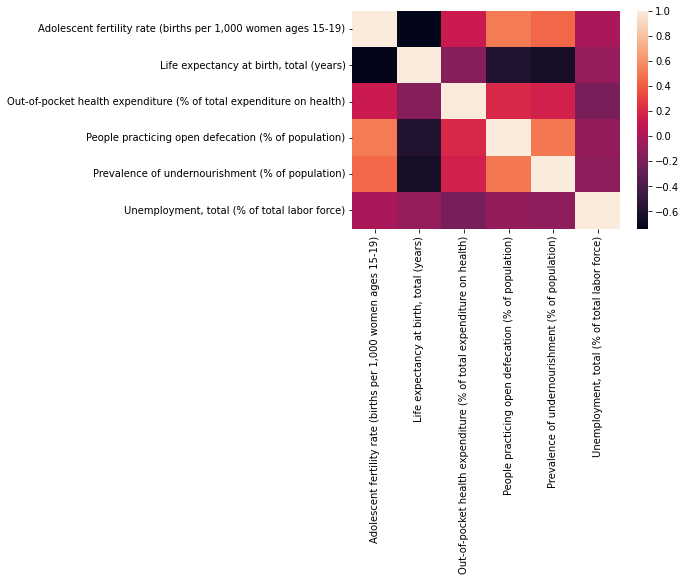

In [13]:
ax = sns.heatmap(no_nulls.corr())

In [14]:
mean_life_expectancy = no_nulls['Life expectancy at birth, total (years)'].mean()
print(mean_life_expectancy)

64.72707558965189


In [15]:
pd.options.mode.chained_assignment = None
no_nulls['above_average'] = [1 if expect > mean_life_expectancy
                            else 0 for expect in no_nulls['Life expectancy at birth, total (years)']]
no_nulls

,Country Name,"Adolescent fertility rate (births per 1,000 women ages 15-19)","Life expectancy at birth, total (years)",Out-of-pocket health expenditure (% of total expenditure on health),People practicing open defecation (% of population),Prevalence of undernourishment (% of population),"Unemployment, total (% of total labor force)",above_average
0,Arab World1999,54.658781,67.403313,38.775874,14.565591,10.384208,12.560328,1
1,Caribbean small states1999,73.554782,70.080801,31.742794,1.911468,10.328210,13.683283,1
3,Early-demographic dividend1999,68.134338,64.128199,41.730719,40.193086,18.824411,6.202662,0
4,East Asia & Pacific1999,19.809457,71.016385,22.597362,8.335003,18.405973,4.834189,1
5,East Asia & Pacific (excluding high income)1999,21.039113,70.017763,52.314289,9.248108,18.757345,4.783419,1
...,...,...,...,...,...,...,...,...
249,Uzbekistan2014,17.817800,68.339024,43.932355,0.000000,5.000000,10.600000,1
251,"Venezuela, RB2014",79.667200,74.236195,64.333652,5.400000,5.000000,8.600000,1
252,Vietnam2014,38.119400,75.629122,36.758840,0.800000,11.800000,2.300000,1
256,Zambia2014,93.015600,60.047049,29.994881,14.300000,48.400000,13.300000,0


In [16]:
combined_data_set_2 = no_nulls.copy()
combined_data_set_2.to_csv('/content/combined_countries.csv')

In [17]:
features = combined_data_set_2[['Adolescent fertility rate (births per 1,000 women ages 15-19)',
                                'Out-of-pocket health expenditure (% of total expenditure on health)',
                                'People practicing open defecation (% of population)',
                                'Prevalence of undernourishment (% of population)',
                         'Unemployment, total (% of total labor force)']]
labels = combined_data_set_2['above_average']

Ok, now we have a few things we want to do with our data for EDA, so let's make 
some clean datasets for each of those things.

Let's start by getting diabetes prevalence in each country and overweight percentage. Diabetes rates are only recorded for 2015, and obesity for 2014, but the rates have low variance, so we can compare across those 2 years 

In [18]:
diabetes_prevalence_2015 = STD_df[["Country Name","Indicator Name", "2015"]]
diabetes_prevalence_2015 = diabetes_prevalence_2015[diabetes_prevalence_2015["Indicator Name"] == "Diabetes prevalence (% of population ages 20 to 79)"]
diabetes_prevalence_2015

,Country Name,Indicator Name,2015
94,Arab World,Diabetes prevalence (% of population ages 20 t...,11.891154
439,Caribbean small states,Diabetes prevalence (% of population ages 20 t...,12.413004
784,Central Europe and the Baltics,Diabetes prevalence (% of population ages 20 t...,6.817486
1129,Early-demographic dividend,Diabetes prevalence (% of population ages 20 t...,9.014930
1474,East Asia & Pacific,Diabetes prevalence (% of population ages 20 t...,8.685275
...,...,...,...
87379,Virgin Islands (U.S.),Diabetes prevalence (% of population ages 20 t...,12.300000
87724,West Bank and Gaza,Diabetes prevalence (% of population ages 20 t...,9.400000
88069,"Yemen, Rep.",Diabetes prevalence (% of population ages 20 t...,5.100000
88414,Zambia,Diabetes prevalence (% of population ages 20 t...,4.100000


In [19]:
diabetes_prevalence_2015 = diabetes_prevalence_2015[["Country Name", "2015"]]
diabetes_prevalence_2015 = diabetes_prevalence_2015.rename(columns  = {"2015" : "diabetes_prevalence"})
diabetes_prevalence_2015
diabetes_prevalence_no_null = diabetes_prevalence_2015.dropna(axis = 0, subset = ["diabetes_prevalence"])
diabetes_prevalence_no_null

,Country Name,diabetes_prevalence
94,Arab World,11.891154
439,Caribbean small states,12.413004
784,Central Europe and the Baltics,6.817486
1129,Early-demographic dividend,9.014930
1474,East Asia & Pacific,8.685275
...,...,...
87379,Virgin Islands (U.S.),12.300000
87724,West Bank and Gaza,9.400000
88069,"Yemen, Rep.",5.100000
88414,Zambia,4.100000


In [20]:
overweight = raw_data_df[raw_data_df["Indicator Name"] == "Prevalence of overweight (% of adults)"]
overweight = overweight[["Country Name", "Indicator Name", "2013", "2014", "2015"]]
overweight_no_null = overweight.dropna(axis = 0, subset= ["2014"])
overweight_no_null = overweight_no_null[["Country Name", "2014"]]
overweight_no_null = overweight_no_null.rename(columns = {"2014": "overweight"})
overweight_no_null

,Country Name,overweight
14424,Afghanistan,16.2
14769,Albania,52.7
15114,Algeria,59.1
15804,Andorra,66.9
16149,Angola,30.9
...,...,...
86874,"Venezuela, RB",62.3
87219,Vietnam,20.6
88254,"Yemen, Rep.",46.8
88599,Zambia,29.2


In [21]:
print(overweight_no_null.dtypes)
print(diabetes_prevalence_no_null.dtypes)

Country Name     object
overweight      float64
dtype: object
Country Name            object
diabetes_prevalence    float64
dtype: object


In [22]:
  obese_and_diabetic_rates = pd.merge(overweight_no_null, diabetes_prevalence_no_null, how = 'inner', on = "Country Name")
  obese_and_diabetic_rates

,Country Name,overweight,diabetes_prevalence
0,Afghanistan,16.2,8.8
1,Albania,52.7,10.3
2,Algeria,59.1,7.5
3,Andorra,66.9,8.5
4,Angola,30.9,4.1
...,...,...,...
185,"Venezuela, RB",62.3,12.0
186,Vietnam,20.6,6.0
187,"Yemen, Rep.",46.8,5.1
188,Zambia,29.2,4.1


In [23]:
syphilis_rates = STD_df[STD_df["Indicator Name"] == "Prevalence of syphilis (% of women attending antenatal care)"]
syphilis_rates_2012 = syphilis_rates[["Country Name", "2012"]]
syphilis_rates_2012 = syphilis_rates_2012.rename(columns={"2012" : "syphilis_rate"})
syphilis_rates_2012

,Country Name,syphilis_rate
288,Arab World,NaN
633,Caribbean small states,0.854979
978,Central Europe and the Baltics,NaN
1323,Early-demographic dividend,1.619218
1668,East Asia & Pacific,1.765545
...,...,...
87573,Virgin Islands (U.S.),NaN
87918,West Bank and Gaza,NaN
88263,"Yemen, Rep.",NaN
88608,Zambia,NaN


# EDA

Ok, so let's get into Exploratory data analytics. We're gonna look at some goofy things that all have negative impacts on your life, and then we're going to use all of these things to predict life expectancy of different countries

Up first: we're going to link **Obesity and Diabetes** and see that there is indeed a correlation between the two. Then, we combine with a nutrition dataset and look at each factor correlated with average sugar content for foods from each country and find that there's actually a minor negative correlation (not statistically significant) between overweight percent of the population and sugar in food, but there's a positive correlation between diabetic population and sugar in food

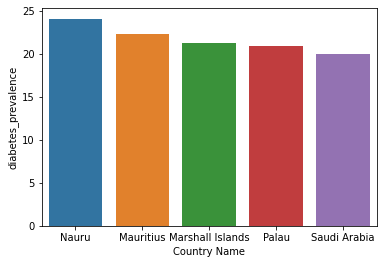

In [24]:
sorted_by_diabetic_rate = obese_and_diabetic_rates.sort_values(by = "diabetes_prevalence", ascending= False)
ax = sns.barplot(x = "Country Name", y = "diabetes_prevalence", data = sorted_by_diabetic_rate[0:5])


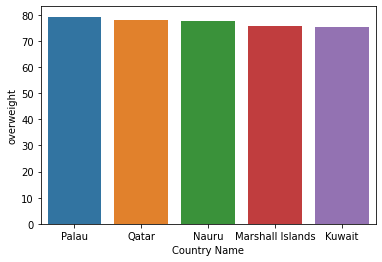

In [25]:
sorted_by_obesity_rate = obese_and_diabetic_rates.sort_values(by = "overweight", ascending= False)
ax = sns.barplot(x = "Country Name", y = "overweight", data = sorted_by_obesity_rate[0:5])

In [26]:
c1 = obese_and_diabetic_rates["overweight"]
c2 = obese_and_diabetic_rates["diabetes_prevalence"]
print(c1.corr(c2))

0.6034725880319263


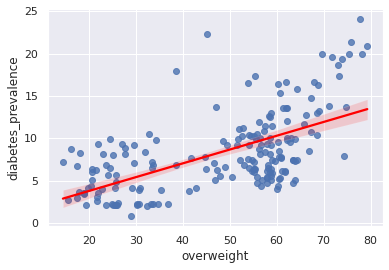

In [27]:
sns.set(color_codes=True)
ax = sns.regplot(x="overweight", y="diabetes_prevalence", data=obese_and_diabetic_rates,line_kws={'color':'red'})

# Checking Sugar Content 
Now, to take this a step further, let's pull in another dataset (the nutrition dataset)

In [28]:
nutrition_data = pd.read_csv('/content/drive/MyDrive/jawns/openfoodfacts.tsv', sep = '\t', error_bad_lines=False)
nutrition_data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,...,NaN,0.0214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,NaN,NaN,Torn & Glasser,torn-glasser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,NaN,NaN,NaN,...,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,NaN,NaN,Grizzlies,grizzlies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.143,NaN,0.00514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,NaN,NaN,Bob's Red Mill,bob-s-red-mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,Organic polenta,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [29]:
sugar_df = nutrition_data[['countries_en', 'sugars_100g']]
sugar_df

,countries_en,sugars_100g
0,France,NaN
1,United States,14.29
2,United States,17.86
3,United States,3.57
4,United States,NaN
...,...,...
356022,United States,0.00
356023,China,NaN
356024,France,NaN
356025,France,NaN


In [30]:
sugar_df_no_null = sugar_df.dropna()
sugar_df_no_null

,countries_en,sugars_100g
1,United States,14.29
2,United States,17.86
3,United States,3.57
5,United States,11.54
7,United States,15.62
...,...,...
356005,France,2.60
356010,France,3.89
356017,France,0.50
356022,United States,0.00


In [31]:
average_sugar_for_country = sugar_df_no_null.groupby(by = "countries_en").mean()
average_sugar_for_country

,sugars_100g
countries_en,
Albania,7.0000
"Albania,Denmark,Italy",1.0000
"Albania,France",16.0000
"Albania,Italy",12.1875
Algeria,2.2000
...,...
السعودية,26.4250
سلطنة-عمان,5.3500
ព្រះរាជាណាចក្រកម្ពុជា,1.3400


Oh no! we have other languages in here (which sux), so let's translate those. Also, commas? gross

In [32]:
average_sugar_for_country = average_sugar_for_country.reset_index()
average_sugar_for_country_no_commas = average_sugar_for_country[~average_sugar_for_country["countries_en"].str.contains(",")]


In [33]:
!pip install googletrans==3.1.0a0

     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 1.3 MB 35.3 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=3d7636a0c11e11eb11b54f867e8c74cc860f9d04dbf4cb14c290a11be654cdae
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [34]:
from googletrans import Translator

translator = Translator(service_urls=['translate.googleapis.com'])

countries_and_sugar = average_sugar_for_country_no_commas

countries_and_sugar["english_countries"] = countries_and_sugar["countries_en"].apply(lambda x : translator.translate(x).text)
countries_and_sugar

,countries_en,sugars_100g,english_countries
0,Albania,7.000000,Albania
4,Algeria,2.200000,Algeria
15,Andorra,8.923333,Andorra
18,Argentina,29.582500,Argentina
22,Aruba,8.000000,Aruba
...,...,...,...
590,السعودية,26.425000,Saudi Arabia
591,سلطنة-عمان,5.350000,Sultanate of Oman
592,ព្រះរាជាណាចក្រកម្ពុជា,1.340000,Kingdom of Cambodia
593,中华人民共和国,12.000000,People's Republic of China


In [35]:
diabetes_and_sugar = pd.merge(countries_and_sugar, obese_and_diabetic_rates, 
                              how = 'inner', left_on = 'english_countries', right_on = 'Country Name')
diabetes_and_sugar

,countries_en,sugars_100g,english_countries,Country Name,overweight,diabetes_prevalence
0,Albania,7.000000,Albania,Albania,52.7,10.3
1,Algeria,2.200000,Algeria,Algeria,59.1,7.5
2,Andorra,8.923333,Andorra,Andorra,66.9,8.5
3,Argentina,29.582500,Argentina,Argentina,61.7,6.0
4,Australia,13.637814,Australia,Australia,64.0,5.1
...,...,...,...,...,...,...
64,Turkey,20.247647,Turkey,Turkey,66.3,12.8
65,Ukraine,20.000000,Ukraine,Ukraine,54.2,6.5
66,United Arab Emirates,30.900000,United Arab Emirates,United Arab Emirates,74.0,19.3
67,United Kingdom,14.742229,United Kingdom,United Kingdom,63.4,4.7


In [36]:
diabetes_and_sugar_clean = diabetes_and_sugar[["countries_en", "sugars_100g", "overweight", "diabetes_prevalence"]]
diabetes_and_sugar_clean

,countries_en,sugars_100g,overweight,diabetes_prevalence
0,Albania,7.000000,52.7,10.3
1,Algeria,2.200000,59.1,7.5
2,Andorra,8.923333,66.9,8.5
3,Argentina,29.582500,61.7,6.0
4,Australia,13.637814,64.0,5.1
...,...,...,...,...
64,Turkey,20.247647,66.3,12.8
65,Ukraine,20.000000,54.2,6.5
66,United Arab Emirates,30.900000,74.0,19.3
67,United Kingdom,14.742229,63.4,4.7


#Final Correlation Between Sugar Content, Diabetic Rates, and Overweight Rates 

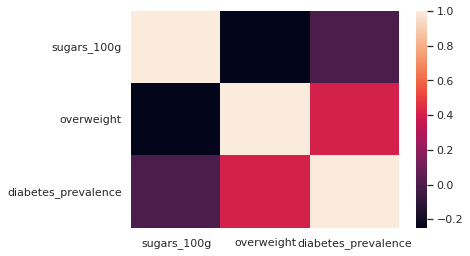

In [37]:
ax = sns.heatmap(diabetes_and_sugar_clean.corr())

So, what we see here is that there is a much larger correlation between obesity and diabetes than there is between obesity and sugary foods. However, for some reason, the diabetes prevalence is weakly correlated to sugar content on average of food in each country

## STD Rates Over Time

ALEX: ADD THINGS HERE ABOUT YOUR DATA

**Secondly** let's take a look at how the Prevalence of syphilis (% of women attending antenatal care) and Incidence of HIV (% of uninfected population ages 15-49 that are newly infected with HIV) have changed over time. To do this we will plot the average Prevalence of  Syphilis and Incidence of HIV across all countries.  

In [38]:
syphilis_df = raw_data_df[
                       (raw_data_df["Indicator Name"] == "Prevalence of syphilis (% of women attending antenatal care)")                    
                     ]
HIV_df = raw_data_df[(raw_data_df["Indicator Name"] == "Incidence of HIV (% of uninfected population ages 15-49)")]

  

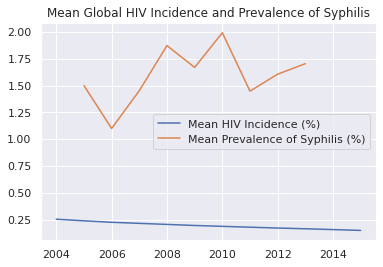

In [39]:
#Want to plot Date on X, Disease occurance on Y, line for 
import matplotlib.pyplot as plt

x_axis = [2004 ,	2005 ,	2006 ,	2007 ,	2008 ,	2009 ,	2010 ,	2011 ,	2012 ,	2013 ,	2014 ,	2015]

#y axis will be a list 
syphilis_labels = []
HIV_labels = []

#compute average HIV incidence for every year 
#0 indicate missing
for i in range(2004, 2016):
  syph_to_push = syphilis_df[str(i)].mean()
  HIV_to_push = HIV_df[str(i)].mean()
  if syph_to_push != np.NaN :
    syphilis_labels.append(syph_to_push)
  else :
    syphilis_labels.append(np.NaN)
  if HIV_to_push != np.NaN :
    HIV_labels.append(HIV_to_push)
  else :
    HIV_labels.append(np.NaN)
  
# plot lines
plt.plot(x_axis, HIV_labels, label = "Mean HIV Incidence (%)")
plt.plot(x_axis, syphilis_labels, label = "Mean Prevalence of Syphilis (%)")
plt.title(label = 'Mean Global HIV Incidence and Prevalence of Syphilis')
plt.legend()
plt.show()


Now, as you can see, on our limited data, syphillis increased over time while HIV dropped. This likely stems from raised awareness of HIV and increased STD testing for Syphillis, but we can't be sure. That said, we'll include the end most recent data on Syphillis and HIV rates in our predictions for the modeling step of the project 

But before we do, let's do another correlation!

In [40]:
print(pd.Series(HIV_labels).corr(pd.Series(syphilis_labels)))
d = {"HIV" : pd.Series(HIV_labels), "Syph" : pd.Series(syphilis_labels)}
HIV_syph = pd.DataFrame(data = d)

-0.4440847716996839


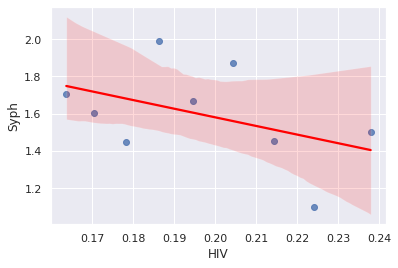

In [41]:
sns.set(color_codes=True)
ax = sns.regplot(x="HIV", y="Syph", data=HIV_syph,line_kws={'color':'red'})

huh, now a negative correlation's a little weird. That kind of implies that as people stop getting AIDS they get more syphillis? Maybe we can explore this more later

#Let's link HIV and Poverty!

In [42]:
raw_data_df_2 = pd.read_csv('/content/drive/MyDrive/jawns/un_data.csv', error_bad_lines=False)
raw_data_df_2 

,Country or Area,Year,Value,Value Footnotes
0,Afghanistan,2016,54.5,1.0
1,Afghanistan,2011,38.3,2.0
2,Afghanistan,2007,33.7,3.0
3,Albania,2012,14.3,4.0
4,Albania,2008,12.4,5.0
...,...,...,...,...
1157,185,Source: Living Conditions Monitoring Survey. P...,NaN,NaN
1158,186,Source: Mini-PICES 2019 (April/ May 2019) Pove...,NaN,NaN
1159,187,Source: Poverty Income and Consumption Expendi...,NaN,NaN
1160,188,Source: Poverty Income and Consumption Expendi...,NaN,NaN


In [43]:
raw_data_df_2 = raw_data_df_2 [~raw_data_df_2['Country or Area'].str.contains(r'\d')]
raw_data_df_2 = raw_data_df_2[["Country or Area", "Year", "Value"]]
raw_data_df_2  = raw_data_df_2.dropna()
raw_data_df_2 

,Country or Area,Year,Value
0,Afghanistan,2016,54.5
1,Afghanistan,2011,38.3
2,Afghanistan,2007,33.7
3,Albania,2012,14.3
4,Albania,2008,12.4
...,...,...,...
968,Zambia,2010,54.7
969,Zimbabwe,2019,38.3
970,Zimbabwe,2017,30.4
971,Zimbabwe,2011,22.5


In [44]:
poverty_index = raw_data_df_2.drop_duplicates(subset = ['Country or Area'])
poverty_index

poverty_index = poverty_index.rename(columns = {"Country or Area": "Country Name"})
poverty_index = poverty_index.rename(columns = {"Value": "poverty index"})
poverty_index

,Country Name,Year,poverty index
0,Afghanistan,2016,54.5
3,Albania,2012,14.3
7,Algeria,2011,5.5
8,Angola,2018,32.3
9,Argentina,2019,35.5
...,...,...,...
957,Vietnam,2018,6.7
962,West Bank and Gaza,2016,29.2
965,Yemen,2014,48.6
967,Zambia,2015,54.4


In [45]:
temp3_df = raw_data_df[(raw_data_df["Indicator Name"] == 'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, female (2 prevent ways and reject 3 misconceptions)')]
temp3_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
82,Arab World,ARB,"Comprehensive correct knowledge of HIV/AIDS, a...",SH.HIV.1524.KW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,Caribbean small states,CSS,"Comprehensive correct knowledge of HIV/AIDS, a...",SH.HIV.1524.KW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772,Central Europe and the Baltics,CEB,"Comprehensive correct knowledge of HIV/AIDS, a...",SH.HIV.1524.KW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1117,Early-demographic dividend,EAR,"Comprehensive correct knowledge of HIV/AIDS, a...",SH.HIV.1524.KW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1462,East Asia & Pacific,EAS,"Comprehensive correct knowledge of HIV/AIDS, a...",SH.HIV.1524.KW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87367,Virgin Islands (U.S.),VIR,"Comprehensive correct knowledge of HIV/AIDS, a...",SH.HIV.1524.KW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87712,West Bank and Gaza,WBG,"Comprehensive correct knowledge of HIV/AIDS, a...",SH.HIV.1524.KW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2,NaN,NaN,NaN,6.2,NaN,NaN
88057,"Yemen, Rep.",YEM,"Comprehensive correct knowledge of HIV/AIDS, a...",SH.HIV.1524.KW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88402,Zambia,ZMB,"Comprehensive correct knowledge of HIV/AIDS, a...",SH.HIV.1524.KW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.6,NaN,NaN,40.5,NaN,34.0,NaN,37.8,NaN,NaN,NaN,NaN,41.5,NaN,NaN


In [46]:
syphilis_df = raw_data_df[
                       (raw_data_df["Indicator Name"] == "Prevalence of syphilis (% of women attending antenatal care)")                    
                     ]
syphilis_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
288,Arab World,ARB,Prevalence of syphilis (% of women attending a...,SH.PRG.SYPH.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
633,Caribbean small states,CSS,Prevalence of syphilis (% of women attending a...,SH.PRG.SYPH.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.854979,NaN,NaN,NaN,NaN
978,Central Europe and the Baltics,CEB,Prevalence of syphilis (% of women attending a...,SH.PRG.SYPH.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1323,Early-demographic dividend,EAR,Prevalence of syphilis (% of women attending a...,SH.PRG.SYPH.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.619218,NaN,NaN,NaN,NaN
1668,East Asia & Pacific,EAS,Prevalence of syphilis (% of women attending a...,SH.PRG.SYPH.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.765545,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87573,Virgin Islands (U.S.),VIR,Prevalence of syphilis (% of women attending a...,SH.PRG.SYPH.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87918,West Bank and Gaza,WBG,Prevalence of syphilis (% of women attending a...,SH.PRG.SYPH.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88263,"Yemen, Rep.",YEM,Prevalence of syphilis (% of women attending a...,SH.PRG.SYPH.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.35,NaN,NaN,NaN,NaN,NaN,NaN
88608,Zambia,ZMB,Prevalence of syphilis (% of women attending a...,SH.PRG.SYPH.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,5.10,5.27,4.68,NaN,4.4,NaN,NaN,NaN


In [47]:
HIV_df = raw_data_df[(raw_data_df["Indicator Name"] == "Incidence of HIV (% of uninfected population ages 15-49)")]
HIV_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
141,Arab World,ARB,Incidence of HIV (% of uninfected population a...,SH.HIV.INCD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011707,0.012782,0.013467,0.014201,0.014873,0.015430,0.015813,0.015942,0.016840,0.016663,0.016081,0.015518,0.015189,0.016194,0.015688,0.015373,0.015325,0.014894,0.014889,0.014785,0.014858,0.014889,0.014785,0.014826,0.014870,0.013476,NaN
486,Caribbean small states,CSS,Incidence of HIV (% of uninfected population a...,SH.HIV.INCD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.168735,0.188237,0.200622,0.214235,0.204025,0.192622,0.192123,0.184759,0.187737,0.180257,0.176079,0.166039,0.160876,0.149931,0.141079,0.130080,0.122611,0.111548,0.106712,0.104010,0.103043,0.101774,0.100751,0.100866,0.096847,0.096903,NaN
831,Central Europe and the Baltics,CEB,Incidence of HIV (% of uninfected population a...,SH.HIV.INCD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1176,Early-demographic dividend,EAR,Incidence of HIV (% of uninfected population a...,SH.HIV.INCD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1521,East Asia & Pacific,EAS,Incidence of HIV (% of uninfected population a...,SH.HIV.INCD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87426,Virgin Islands (U.S.),VIR,Incidence of HIV (% of uninfected population a...,SH.HIV.INCD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87771,West Bank and Gaza,WBG,Incidence of HIV (% of uninfected population a...,SH.HIV.INCD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88116,"Yemen, Rep.",YEM,Incidence of HIV (% of uninfected population a...,SH.HIV.INCD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,NaN
88461,Zambia,ZMB,Incidence of HIV (% of uninfected population a...,SH.HIV.INCD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.460000,2.340000,2.270000,2.160000,2.080000,1.990000,1.920000,1.830000,1.760000,1.690000,1.600000,1.620000,1.530000,1.440000,1.370000,1.280000,1.220000,1.170000,1.130000,1.060000,1.080000,1.040000,1.010000,0.970000,0.920000,0.8

In [48]:
HIV_df = HIV_df[["Country Name","Indicator Name", "2015"]]
HIV_df = HIV_df[(HIV_df["Indicator Name"] == 'Incidence of HIV (% of uninfected population ages 15-49)') ]
#incidence_tb = incidence_tb.dropna(subset = ['2012', '2013', '2014'])
HIV_df = HIV_df.dropna().reset_index(drop = True)

HIV_df = HIV_df[["Country Name", "2015"]]



HIV_df = HIV_df.rename(columns = {"2015": "hiv_incidence"})

#prevalance_tb = prevalance_tb[["Country Name", "2014"]]
#prevalance_tb = prevalance_tb.rename(columns = {"2014": "prevalance_tb"})
#prevalance_tb

HIV_df

,Country Name,hiv_incidence
0,Arab World,0.013476
1,Caribbean small states,0.096903
2,Fragile and conflict affected situations,0.082332
3,Heavily indebted poor countries (HIPC),0.160105
4,Latin America & Caribbean,0.030729
...,...,...
119,"Venezuela, RB",0.030000
120,Vietnam,0.030000
121,"Yemen, Rep.",0.010000
122,Zambia,0.850000


In [49]:
syphilis_df = syphilis_df[["Country Name","Indicator Name", "2012"]]
syphilis_df = syphilis_df[(syphilis_df["Indicator Name"] == 'Prevalence of syphilis (% of women attending antenatal care)') ]
#incidence_tb = incidence_tb.dropna(subset = ['2012', '2013', '2014'])
syphilis_df = syphilis_df.dropna().reset_index(drop = True)

syphilis_df = syphilis_df[["Country Name", "2012"]]



syphilis_df = syphilis_df.rename(columns = {"2012": "syphiliis_incidence"})

syphilis_df

,Country Name,syphiliis_incidence
0,Caribbean small states,0.854979
1,Early-demographic dividend,1.619218
2,East Asia & Pacific,1.765545
3,East Asia & Pacific (excluding high income),1.858976
4,East Asia & Pacific (IDA & IBRD countries),1.961870
...,...,...
88,United Arab Emirates,0.000000
89,United Kingdom,0.100000
90,Uruguay,1.508890
91,Vietnam,0.027770


In [50]:
std_merged = pd.merge(syphilis_df, HIV_df, how = 'inner', on = "Country Name")
std_merged 

,Country Name,syphiliis_incidence,hiv_incidence
0,Caribbean small states,0.854979,0.096903
1,Fragile and conflict affected situations,3.901401,0.082332
2,Heavily indebted poor countries (HIPC),2.593249,0.160105
3,Latin America & Caribbean,0.844126,0.030729
4,Latin America & Caribbean (excluding high income),0.881976,0.030838
...,...,...,...
56,Sri Lanka,0.091050,0.010000
57,Thailand,0.055950,0.020000
58,Uruguay,1.508890,0.030000
59,Vietnam,0.027770,0.030000


In [51]:
std_poverty = pd.merge(poverty_index, std_merged, how = 'inner', on = "Country Name")
std_poverty

,Country Name,Year,poverty index,syphiliis_incidence,hiv_incidence
0,Armenia,2019,26.4,0.00000,0.03
1,Belarus,2019,5,0.03259,0.10
2,Bolivia,2019,37.2,1.28081,0.02
3,Burkina Faso,2018,41.4,1.70000,0.05
4,Cabo Verde,2015,35,1.02018,0.06
5,Cambodia,2012,17.7,0.07248,0.01
6,Chad,2018,42.3,4.70472,0.10
7,Colombia,2019,35.7,0.60000,0.04
8,Dominican Republic,2019,21,3.36242,0.04
9,El Salvador,2019,22.8,0.24600,0.01


# What our data says about TB and Poverty

PRAK: ADD THINGS HERE ABOUT YOUR DATA

In [52]:
temp_df = raw_data_df[(raw_data_df["Indicator Name"] == 'Prevalence of tuberculosis (per 100,000 population)') | 
                     (raw_data_df["Indicator Name"] == 'Tuberculosis case detection rate (all forms)')]
temp_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
289,Arab World,ARB,"Prevalence of tuberculosis (per 100,000 popula...",SH.TBS.PREV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328,Arab World,ARB,Tuberculosis case detection rate (all forms),SH.TBS.DTEC.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
634,Caribbean small states,CSS,"Prevalence of tuberculosis (per 100,000 popula...",SH.TBS.PREV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
673,Caribbean small states,CSS,Tuberculosis case detection rate (all forms),SH.TBS.DTEC.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
979,Central Europe and the Baltics,CEB,"Prevalence of tuberculosis (per 100,000 popula...",SH.TBS.PREV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88303,"Yemen, Rep.",YEM,Tuberculosis case detection rate (all forms),SH.TBS.DTEC.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,40.0,55.0,57.0,57.0,68.0,67.0,55.0,57.0,62.0,66.0,65.0,61.0,57.0,58.0,55.0,55.0,59.0,62.0,67.0,73.0,72.0,82.0,84.0,77.0,NaN,NaN
88609,Zambia,ZMB,"Prevalence of tuberculosis (per 100,000 popula...",SH.TBS.PREV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,820.0,810.0,812.0,815.0,815.0,812.0,800.0,779.0,753.0,725.0,694.0,661.0,629.0,600.0,573.0,548.0,528.0,510.0,493.0,450.0,424.0,465.0,468.0,455.0,436.0,NaN,NaN
88648,Zambia,ZMB,Tuberculosis case detection rate (all forms),SH.TBS.DTEC.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,36.0,37.0,42.0,47.0,46.0,50.0,NaN,NaN,56.0,62.0,59.0,70.0,76.0,73.0,68.0,67.0,66.0,62.0,65.0,64.0,64.0,60.0,61.0,59.0,NaN,NaN
88954,Zimbabwe,ZWE,"Prevalence of tuberculosis (per 100,000 popula...",SH.TBS.PREV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,363.0,331.0,316.0,315.0,322.0,336.0,357.0,381.0,412.0,438.0,457.0,470.0,475.0,481.0,481.0,475.0,460.0,438.0,408.0,359.0,335.0,327.0,313.0,276.0,292.0,NaN,NaN


In [53]:
prevalance_tb = temp_df[["Country Name","Indicator Name", "2014"]]
prevalance_tb = prevalance_tb[(prevalance_tb["Indicator Name"] == 'Prevalence of tuberculosis (per 100,000 population)') ]
#incidence_tb = incidence_tb.dropna(subset = ['2012', '2013', '2014'])
prevalance_tb = prevalance_tb.dropna().reset_index(drop = True)

prevalance_tb = prevalance_tb[["Country Name", "2014"]]
prevalance_tb = prevalance_tb.rename(columns = {"2014": "prevalance_tb"})
prevalance_tb

,Country Name,prevalance_tb
0,East Asia & Pacific,193.0
1,East Asia & Pacific (excluding high income),209.0
2,Europe & Central Asia,48.0
3,Europe & Central Asia (excluding high income),82.0
4,High income,26.0
...,...,...
224,Virgin Islands (U.S.),9.9
225,West Bank and Gaza,7.1
226,"Yemen, Rep.",63.0
227,Zambia,436.0


In [54]:
detection_tb = temp_df[["Country Name","Indicator Name", "2014"]]
detection_tb= detection_tb[(detection_tb["Indicator Name"] == 'Tuberculosis case detection rate (all forms)') ]

detection_tb = detection_tb.dropna().reset_index(drop = True)

detection_tb = detection_tb[["Country Name", "2014"]]
detection_tb = detection_tb.rename(columns = {"2014": "detection rate"})

detection_tb

,Country Name,detection rate
0,East Asia & Pacific,66.0
1,East Asia & Pacific (excluding high income),65.0
2,Europe & Central Asia,81.0
3,Europe & Central Asia (excluding high income),80.0
4,High income,85.0
...,...,...
214,Vietnam,77.0
215,West Bank and Gaza,16.0
216,"Yemen, Rep.",77.0
217,Zambia,59.0


In [55]:
tb_merged = pd.merge(prevalance_tb, detection_tb, how = 'inner', on = "Country Name")
tb_merged 

,Country Name,prevalance_tb,detection rate
0,East Asia & Pacific,193.0,66.0
1,East Asia & Pacific (excluding high income),209.0,65.0
2,Europe & Central Asia,48.0,81.0
3,Europe & Central Asia (excluding high income),82.0,80.0
4,High income,26.0,85.0
...,...,...,...
214,Vietnam,198.0,77.0
215,West Bank and Gaza,7.1,16.0
216,"Yemen, Rep.",63.0,77.0
217,Zambia,436.0,59.0


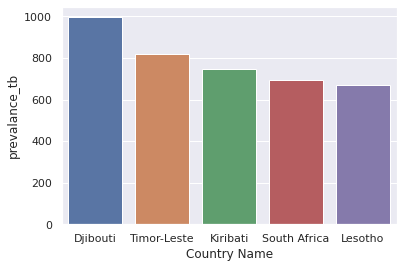

In [56]:
tb_merged_sorted = tb_merged.sort_values(by = "prevalance_tb", ascending= False)
ax = sns.barplot(x = "Country Name", y = "prevalance_tb", data = tb_merged_sorted[0:5])


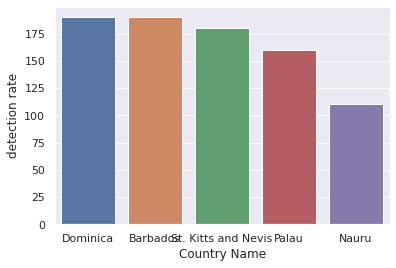

In [57]:
tb_merged_sorted = tb_merged.sort_values(by = "detection rate", ascending= False)
ax = sns.barplot(x = "Country Name", y = "detection rate", data = tb_merged_sorted[0:5])

In [58]:
c1 = tb_merged_sorted["detection rate"]
c2 = tb_merged_sorted["prevalance_tb"]

print(c2.corr(c1))

-0.3169891487239457


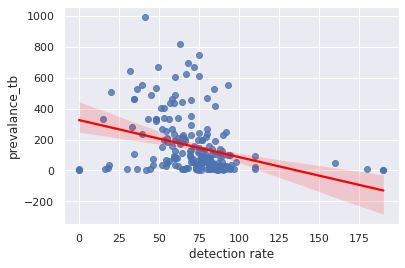

In [59]:
tb_corr = tb_merged_sorted.corr()
sns.set(color_codes=True)
ax = sns.regplot(x="detection rate", y="prevalance_tb", data=tb_merged_sorted,line_kws={'color':'red'})

In [60]:
tb_poverty = pd.merge(poverty_index, tb_merged_sorted, how = 'inner', on = "Country Name")
tb_poverty

,Country Name,Year,poverty index,prevalance_tb,detection rate
0,Afghanistan,2016,54.5,340.0,53.0
1,Albania,2012,14.3,26.0,75.0
2,Algeria,2011,5.5,118.0,74.0
3,Angola,2018,32.3,490.0,60.0
4,Argentina,2019,35.5,30.0,89.0
...,...,...,...,...,...
137,Vanuatu,2010,12.7,90.0,69.0
138,Vietnam,2018,6.7,198.0,77.0
139,West Bank and Gaza,2016,29.2,7.1,16.0
140,Zambia,2015,54.4,436.0,59.0


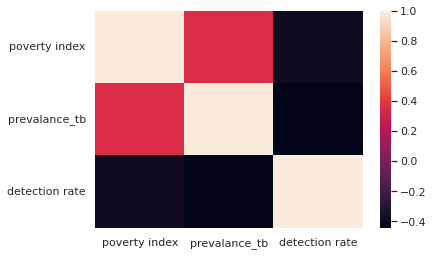

In [61]:
tb_pov_no_year = tb_poverty.drop(axis = 1, columns = ["Year"])

tb_pov_no_year = tb_pov_no_year.astype({"poverty index" : "float"})

ax = sns.heatmap(tb_pov_no_year.corr())

Now let's build a Naive Bayes Classifier to predict whether country has an above or below average life expectency given the features and labels created prior. 

#MODELING

#Naive Bayes

In [62]:
from sklearn.model_selection import train_test_split

temp = train_test_split(features, labels, test_size=.299, train_size=.701, random_state=42)
x_train = temp[0]
x_test = temp[1]
y_train = temp[2]
y_test = temp[3]

In [63]:
from sklearn.naive_bayes import GaussianNB

#initialize model
clf = GaussianNB()
#train model
clf.fit(x_train, y_train)
#make predictions
y_pred = clf.predict(x_test)

In [64]:
naive_bayes_acc = clf.score(x_test, y_test)

In [65]:
naive_bayes_acc

0.9008782936010038

#PCA

In [66]:
from sklearn.model_selection import train_test_split

temp = train_test_split(features, labels, test_size=.2, train_size=.8, random_state=42)
x_train = temp[0]
x_test = temp[1]
y_train = temp[2]
y_test = temp[3]

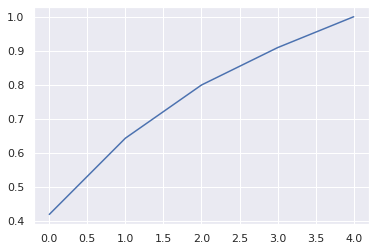

In [67]:
# TO DO PCA
# scaling
# find num components to use
import sklearn.preprocessing 
import sklearn.decomposition
import numpy as np
scale = sklearn.preprocessing.StandardScaler()
fit_train = scale.fit_transform(x_train)
scaled_test = scale.transform(x_test)
# TO DO plot for explained variance
pca_model = sklearn.decomposition.PCA()
pca_model.fit(fit_train)
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))

And now, we see that we don't actually need PCA. Our 5 features are distinct/not correlated enough that PCA adds little benefit

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# TODO
rf = RandomForestClassifier(n_estimators = 100)
grid = GridSearchCV(rf, {'max_depth' : [5, 10, 15]})
rf_cv = grid.fit(x_train, y_train)

In [69]:
rf2 = RandomForestClassifier(n_estimators = 100, max_depth= 15)
rf2.fit(x_train, y_train)
predictions = rf2.predict(x_test)
test_accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print(test_accuracy)

0.9774859287054409


log reg

In [70]:
features_lin_reg = combined_data_set_2[['Adolescent fertility rate (births per 1,000 women ages 15-19)',
                                'Out-of-pocket health expenditure (% of total expenditure on health)',
                                'People practicing open defecation (% of population)',
                                'Prevalence of undernourishment (% of population)',
                         'Unemployment, total (% of total labor force)']]
labels_lin_reg = combined_data_set_2["Life expectancy at birth, total (years)"]

In [71]:
from sklearn.model_selection import train_test_split

temp = train_test_split(features_lin_reg, labels_lin_reg, test_size=.299, train_size=.701, random_state=42)
x_train = temp[0]
x_test = temp[1]
y_train = temp[2]
y_test = temp[3]

In [73]:
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linReg = linReg.fit(x_train, y_train)
score = linReg.score(x_test, y_test)
score

0.7010796991773267